## About this notebook
This notebook defines the Image Evaluate function that we'll use in our adversarial attacks, using various imported pre-trained deep NN's.
Daniel Mckenzie
October 23rd 2020

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import itertools

In [2]:
## Fetch inceptionv3
inception = models.inception_v3(pretrained=True)

In [3]:
## Test evaluations

In [68]:
torchvision.datasets.CIFAR10(root = "./datasets/CIFAR10", download = False,train=False)

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./datasets/CIFAR10
    Transforms (if any): None
    Target Transforms (if any): None

In [69]:
normalize = transforms.Compose([transforms.Resize(299), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
CIFAR10_data = torchvision.datasets.CIFAR10(root = "./datasets/CIFAR10", download = False,train= False, transform=normalize)

In [70]:
data_loader = torch.utils.data.DataLoader(CIFAR10_data, batch_size = 1, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


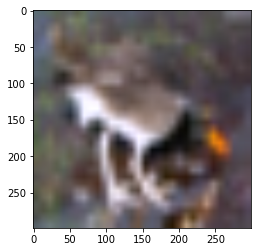

In [71]:
## View an image

inv_normalize = torchvision.transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.255], 
                                                std = [1/0.229,1/0.224, 1/0.255])
def imshow(img):
    img = inv_normalize(img)  # invert the normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
## Fetch some images
dataiter = iter(data_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [72]:
## Test classification accuracy
# Don't 
correct = 0
total = 0
with torch.no_grad():
    for data in itertools.islice(data_loader, 2):
        images, labels = data
        outputs = inception(images)
        predicted = torch.max(outputs[0],1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of network: %d %%' %(100*correct/total))

RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [73]:
images, labels = dataiter.next()
with torch.no_grad():
    inception.eval()
    outputs = inception(images)
pred_labels,pred_score = torch.topk(outputs,2,1)
print(pred_labels, pred_score)

tensor([[4.1854, 3.8397]]) tensor([[734, 517]])


In [74]:
def ImageEvaluate(images, true_label,kappa):
    # Image evaluate, with batch_size = 1
    with torch.no_grad():
        inception.eval()
        outputs = inception(images)
        predicted = torch.max(outputs,1)[1]
        print(predicted)
        f_tru = np.squeeze(outputs[0,true_label.numpy()].numpy())
        print(f_tru)
        pred_top_2_scores, pred_top_2_labels = torch.topk(outputs,2,1)
        print(pred_top_2_labels.shape)
        if true_label == pred_top_2_labels[0,0]:
            f_Ntru = pred_top_2_scores[0,1].numpy()
        else:
            f_Ntru = pred_top_2_scores[0,0].numpy()
        print(f_Ntru)
        val = np.amax([-kappa,f_tru - f_Ntru])
    return val    
    
    

In [75]:
images, labels = dataiter.next()
kappa = 0.1
print(labels.numpy())
vals = ImageEvaluate(images, labels, kappa)
print(vals)

[2]
tensor([429])
-0.8789441
torch.Size([1, 2])
2.6084137
-0.1


## Note
The Image Evaluate function is, I believe, correct. The reason it is returning somewhat nonsensical results is that the Inception-v3 model we are using is trained on ImageNet, but we're using it on C